In [84]:
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats
from statsmodels.tsa.stattools import coint
import seaborn
import math as math

In [126]:
symbols = "GOOG"
start_date ='2015-01-01'
end_date = '2018-01-01'
df = pdr.DataReader(symbols, 'yahoo', start_date,end_date)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-12-31,531.141724,524.360352,529.795471,524.958740,1368246.0,524.958740
2015-01-02,529.815369,522.665039,527.561584,523.373108,1447563.0,523.373108
2015-01-05,522.894409,511.655243,521.827332,512.463013,2059840.0,512.463013
2015-01-06,514.761719,499.678131,513.589966,500.585632,2899940.0,500.585632
2015-01-07,505.855164,498.281952,505.611847,499.727997,2065054.0,499.727997
...,...,...,...,...,...,...
2017-12-22,1064.199951,1059.439941,1061.109985,1060.119995,755100.0,1060.119995
2017-12-26,1060.119995,1050.199951,1058.069946,1056.739990,760600.0,1056.739990
2017-12-27,1058.369995,1048.050049,1057.390015,1049.369995,1271900.0,1049.369995


In [127]:
# "Variables/constants for EMA Calculation:
NUM_PERIODS_FAST = 10 # Static time period parameter for the fast EMA
K_FAST = 2 / (NUM_PERIODS_FAST + 1) # Static smoothing factor parameter for fast EMA
ema_fast = 0
ema_fast_values = [] # we will hold fast EMA values for visualization purposes
NUM_PERIODS_SLOW = 40 # Static time period parameter for slow EMA
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1) # Static smoothing factor parameter for slow EMA
ema_slow = 0
ema_slow_values = [] # we will hold slow EMA values for visualization purposes
apo_values = [] # track computed absolute price oscillator value signals

In [128]:
orders = [] # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = [] # Container for tracking positions, +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = [] # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price

last_buy_price = 0 # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0 # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0 # Current position of the trading strategy
buy_sum_price_qty = 0 # Summation of products of buy_trade_price and buy_trade_qty for every buy Trade made since last time being flat
buy_sum_qty = 0 # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0 # Summation of products of sell_trade_price and sell_trade_qty for every sell Trade made since last time being flat
sell_sum_qty = 0 # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0 # Open/Unrealized PnL marked to market
closed_pnl = 0 # Closed/Realized PnL so far

In [129]:
# Constants that define strategy behavior/thresholds
APO_VALUE_FOR_BUY_ENTRY = -10 # APO trading signal value below which to enter buy-orders/long-position
APO_VALUE_FOR_SELL_ENTRY = 10 # APO trading signal value above which to enter sell-orders/short-position
#sell/short signal when ema_fast - ema_slow is above 10, short term trend is moving up faster than long term trend meaning reversion expected
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10 # Minimum price change since last trade before considering trading again, this is to prevent over-trading at/around same prices
NUM_SHARES_PER_TRADE = 10 # Number of shares to buy/sell on every trade
MIN_PROFIT_TO_CLOSE = 10*NUM_SHARES_PER_TRADE # Minimum Open/Unrealized profit at which to close positions and lock profits

In [130]:
close=df['Close']
for close_price in close:
  # This section updates fast and slow EMA and computes APO trading signal
  if (ema_fast == 0): # first observation
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_FAST + ema_fast
    ema_slow = (close_price - ema_slow) * K_SLOW + ema_slow

  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)

  apo = ema_fast - ema_slow
  apo_values.append(apo)

  # This section checks trading signal against trading parameters/thresholds and positions, to trade.

  # We will perform a sell trade at close_price if the following conditions are met:
  # 1. The APO trading signal value is below Sell-Entry threshold and the difference between last trade-price and current-price is different enough.
  # 2. We are long( +ve position ) and either APO trading signal value is at or below 0 or current position is profitable enough to lock profit.
  if ((apo > APO_VALUE_FOR_SELL_ENTRY and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE) # APO above sell entry threshold, we should sell
    or
    (position > 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))): # long from +ve APO and APO has gone negative or position is profitable, sell to close position
    orders.append(-1) # mark the sell trade
    last_sell_price = close_price
    position -= NUM_SHARES_PER_TRADE # reduce position by the size of this trade
    sell_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update vwap sell-price
    sell_sum_qty += NUM_SHARES_PER_TRADE
    print( "Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )

  # We will perform a buy trade at close_price if the following conditions are met:
  # 1. The APO trading signal value is above Buy-Entry threshold and the difference between last trade-price and current-price is different enough.
  # 2. We are short( -ve position ) and either APO trading signal value is at or above 0 or current position is profitable enough to lock profit.
  elif ((apo < APO_VALUE_FOR_BUY_ENTRY and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE) # APO above buy entry threshold, we should buy
    or
    (position < 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))): # short from -ve APO and APO has gone positive or position is profitable, buy to close position
    orders.append(+1) # mark the buy trade
    last_buy_price = close_price
    position += NUM_SHARES_PER_TRADE # increase position by the size of this trade
    buy_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update the vwap buy-price
    buy_sum_qty += NUM_SHARES_PER_TRADE
    print( "Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )
  else:
    # No trade since none of the conditions were met to buy or sell
    orders.append(0)

  positions.append(position)

  # This section updates Open/Unrealized & Closed/Realized positions
  open_pnl = 0
  if position > 0:
    if sell_sum_qty > 0: # long position and some sell trades have been made against it, close that amount based on how much was sold against this long position
      open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
    open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
  elif position < 0:
    if buy_sum_qty > 0: # short position and some buy trades have been made against it, close that amount based on how much was bought against this short position
      open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
    open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
  else:
    # flat, so update closed_pnl and reset tracking variables for positions & pnls
    closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
    buy_sum_price_qty = 0
    buy_sum_qty = 0
    sell_sum_price_qty = 0
    sell_sum_qty = 0
    last_buy_price = 0
    last_sell_price = 0

  print( "OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl) )
  pnls.append(closed_pnl + open_pnl)

OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
Buy  10  @  494.8114929199219 Position:  10
OpenPnL:  0.0  ClosedPnL:  0  TotalPnL:  0.0
Sell  10  @  491.201416015625 Position:  0
OpenPnL:  0  ClosedPnL:  -36.10076904296875  TotalPnL:  -36.10076904296875
Buy  10  @  494.82147216796875 Position:  10
OpenPnL:  0.0  ClosedPnL:  -36.10076904296875  TotalPnL:  -36.10076904296875
Sell  10  @  499.4986267089844 Position:  0
OpenPnL:  0  ClosedPnL:  10.6707763671875  TotalPnL:  10.6707763671875
Buy  10  @  500.4161071777344 Position:  10
OpenPnL:  0.0  ClosedPnL:  10.6707763671875  TotalPnL:  10.6707763671875
Sell  10  @  506.6888732910156 Position:  0
OpenPnL:  0  ClosedPnL:  73.3984375  TotalPnL:  73.3984375
Buy  10  @  505.5121154785156 Position:  10
OpenPnL:  0.0  ClosedPnL:  73.3984375  TotalPn

OpenPnL:  0.0  ClosedPnL:  434.81903076171875  TotalPnL:  434.81903076171875
Buy  10  @  659.5599975585938 Position:  0
OpenPnL:  0  ClosedPnL:  447.01934814453125  TotalPnL:  447.01934814453125
Sell  10  @  656.4500122070312 Position:  -10
OpenPnL:  0.0  ClosedPnL:  447.01934814453125  TotalPnL:  447.01934814453125
Buy  10  @  657.1199951171875 Position:  0
OpenPnL:  0  ClosedPnL:  440.31951904296875  TotalPnL:  440.31951904296875
Sell  10  @  660.8699951171875 Position:  -10
OpenPnL:  0.0  ClosedPnL:  440.31951904296875  TotalPnL:  440.31951904296875
Buy  10  @  656.1300048828125 Position:  0
OpenPnL:  0  ClosedPnL:  487.71942138671875  TotalPnL:  487.71942138671875
Sell  10  @  660.9000244140625 Position:  -10
OpenPnL:  0.0  ClosedPnL:  487.71942138671875  TotalPnL:  487.71942138671875
Sell  10  @  646.8300170898438 Position:  -20
OpenPnL:  140.7000732421875  ClosedPnL:  487.71942138671875  TotalPnL:  628.4194946289062
Sell  10  @  612.47998046875 Position:  -30
OpenPnL:  827.700805

Buy  10  @  738.0599975585938 Position:  0
OpenPnL:  0  ClosedPnL:  846.7190551757812  TotalPnL:  846.7190551757812
Sell  10  @  735.2999877929688 Position:  -10
OpenPnL:  0.0  ClosedPnL:  846.7190551757812  TotalPnL:  846.7190551757812
Buy  10  @  733.530029296875 Position:  0
OpenPnL:  0  ClosedPnL:  864.4186401367188  TotalPnL:  864.4186401367188
Sell  10  @  744.77001953125 Position:  -10
OpenPnL:  0.0  ClosedPnL:  864.4186401367188  TotalPnL:  864.4186401367188
Buy  10  @  750.530029296875 Position:  0
OpenPnL:  0  ClosedPnL:  806.8185424804688  TotalPnL:  806.8185424804688
Sell  10  @  744.9500122070312 Position:  -10
OpenPnL:  0.0  ClosedPnL:  806.8185424804688  TotalPnL:  806.8185424804688
Buy  10  @  749.9099731445312 Position:  0
OpenPnL:  0  ClosedPnL:  757.2189331054688  TotalPnL:  757.2189331054688
Sell  10  @  745.2899780273438 Position:  -10
OpenPnL:  0.0  ClosedPnL:  757.2189331054688  TotalPnL:  757.2189331054688
Buy  10  @  737.7999877929688 Position:  0
OpenPnL:  0  

OpenPnL:  0  ClosedPnL:  1170.1181030273438  TotalPnL:  1170.1181030273438
OpenPnL:  0  ClosedPnL:  1170.1181030273438  TotalPnL:  1170.1181030273438
OpenPnL:  0  ClosedPnL:  1170.1181030273438  TotalPnL:  1170.1181030273438
OpenPnL:  0  ClosedPnL:  1170.1181030273438  TotalPnL:  1170.1181030273438
OpenPnL:  0  ClosedPnL:  1170.1181030273438  TotalPnL:  1170.1181030273438
OpenPnL:  0  ClosedPnL:  1170.1181030273438  TotalPnL:  1170.1181030273438
OpenPnL:  0  ClosedPnL:  1170.1181030273438  TotalPnL:  1170.1181030273438
OpenPnL:  0  ClosedPnL:  1170.1181030273438  TotalPnL:  1170.1181030273438
OpenPnL:  0  ClosedPnL:  1170.1181030273438  TotalPnL:  1170.1181030273438
OpenPnL:  0  ClosedPnL:  1170.1181030273438  TotalPnL:  1170.1181030273438
OpenPnL:  0  ClosedPnL:  1170.1181030273438  TotalPnL:  1170.1181030273438
OpenPnL:  0  ClosedPnL:  1170.1181030273438  TotalPnL:  1170.1181030273438
OpenPnL:  0  ClosedPnL:  1170.1181030273438  TotalPnL:  1170.1181030273438
OpenPnL:  0  ClosedPnL:  

OpenPnL:  0  ClosedPnL:  893.8162231445312  TotalPnL:  893.8162231445312
Sell  10  @  932.1699829101562 Position:  -10
OpenPnL:  0.0  ClosedPnL:  893.8162231445312  TotalPnL:  893.8162231445312
Buy  10  @  928.780029296875 Position:  0
OpenPnL:  0  ClosedPnL:  927.7157592773438  TotalPnL:  927.7157592773438
Sell  10  @  930.5999755859375 Position:  -10
OpenPnL:  0.0  ClosedPnL:  927.7157592773438  TotalPnL:  927.7157592773438
Buy  10  @  932.219970703125 Position:  0
OpenPnL:  0  ClosedPnL:  911.5158081054688  TotalPnL:  911.5158081054688
Sell  10  @  937.0800170898438 Position:  -10
OpenPnL:  0.0  ClosedPnL:  911.5158081054688  TotalPnL:  911.5158081054688
Buy  10  @  943.0 Position:  0
OpenPnL:  0  ClosedPnL:  852.3159790039062  TotalPnL:  852.3159790039062
Sell  10  @  919.6199951171875 Position:  -10
OpenPnL:  0.0  ClosedPnL:  852.3159790039062  TotalPnL:  852.3159790039062
Sell  10  @  930.239990234375 Position:  -20
OpenPnL:  -106.199951171875  ClosedPnL:  852.3159790039062  Tota

OpenPnL:  -239.833984375  ClosedPnL:  1847.0169067382812  TotalPnL:  1607.1829223632812
Sell  10  @  1030.9300537109375 Position:  -30
OpenPnL:  -561.7019653320312  ClosedPnL:  1847.0169067382812  TotalPnL:  1285.31494140625
Buy  10  @  1037.050048828125 Position:  -20
OpenPnL:  -1031.6021728515625  ClosedPnL:  1847.0169067382812  TotalPnL:  815.4147338867188
Sell  10  @  1041.0999755859375 Position:  -30
OpenPnL:  -1087.3593750000032  ClosedPnL:  1847.0169067382812  TotalPnL:  759.6575317382781
Buy  10  @  1040.47998046875 Position:  -20
OpenPnL:  -1262.6394042968764  ClosedPnL:  1847.0169067382812  TotalPnL:  584.3775024414049
Buy  10  @  1040.6099853515625 Position:  -10
OpenPnL:  -1476.719482421879  ClosedPnL:  1847.0169067382812  TotalPnL:  370.29742431640216
Buy  10  @  1049.1500244140625 Position:  0
OpenPnL:  0  ClosedPnL:  1115.2163696289062  TotalPnL:  1115.2163696289062
Sell  10  @  1064.18994140625 Position:  -10
OpenPnL:  0.0  ClosedPnL:  1115.2163696289062  TotalPnL:  111

In [131]:
data = pd.DataFrame()
data = data.assign(ClosePrice=pd.Series(close, index=df.index))
data = data.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=data.index))
data = data.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=data.index))
data = data.assign(APO=pd.Series(apo_values, index=data.index))
data = data.assign(Trades=pd.Series(orders, index=data.index))
data = data.assign(Position=pd.Series(positions, index=data.index))
data = data.assign(OpenPNL=pd.Series(open_pnl, index=data.index))
data = data.assign(ClosedPNL=pd.Series(closed_pnl, index=data.index))
data = data.assign(Pnl=pd.Series(pnls, index=data.index))
data

,ClosePrice,Fast10DayEMA,Slow40DayEMA,APO,Trades,Position,OpenPNL,ClosedPNL,Pnl
Date,,,,,,,,,
2014-12-31,524.958740,524.958740,524.958740,0.000000,0,0,0,1324.814758,0.000000
2015-01-02,523.373108,524.670443,524.881392,-0.210949,0,0,0,1324.814758,0.000000
2015-01-05,512.463013,522.450911,524.275618,-1.824707,0,0,0,1324.814758,0.000000
2015-01-06,500.585632,518.475405,523.120009,-4.644603,0,0,0,1324.814758,0.000000
2015-01-07,499.727997,515.066786,521.978935,-6.912149,0,0,0,1324.814758,0.000000
...,...,...,...,...,...,...,...,...,...
2017-12-22,1060.119995,1056.346757,1029.840863,26.505894,1,0,0,1324.814758,1233.714905
2017-12-26,1056.739990,1056.418254,1031.153016,25.265238,-1,-10,0,1324.814758,1233.714905
2017-12-27,1049.369995,1055.136753,1032.041649,23.095104,1,0,0,1324.814758,1307.414856


In [132]:
#fontsize effects size
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 12px }</style> 
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=yes, scrollbars=yes, resizable=yes, width=780, height=1000, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))

View(data)

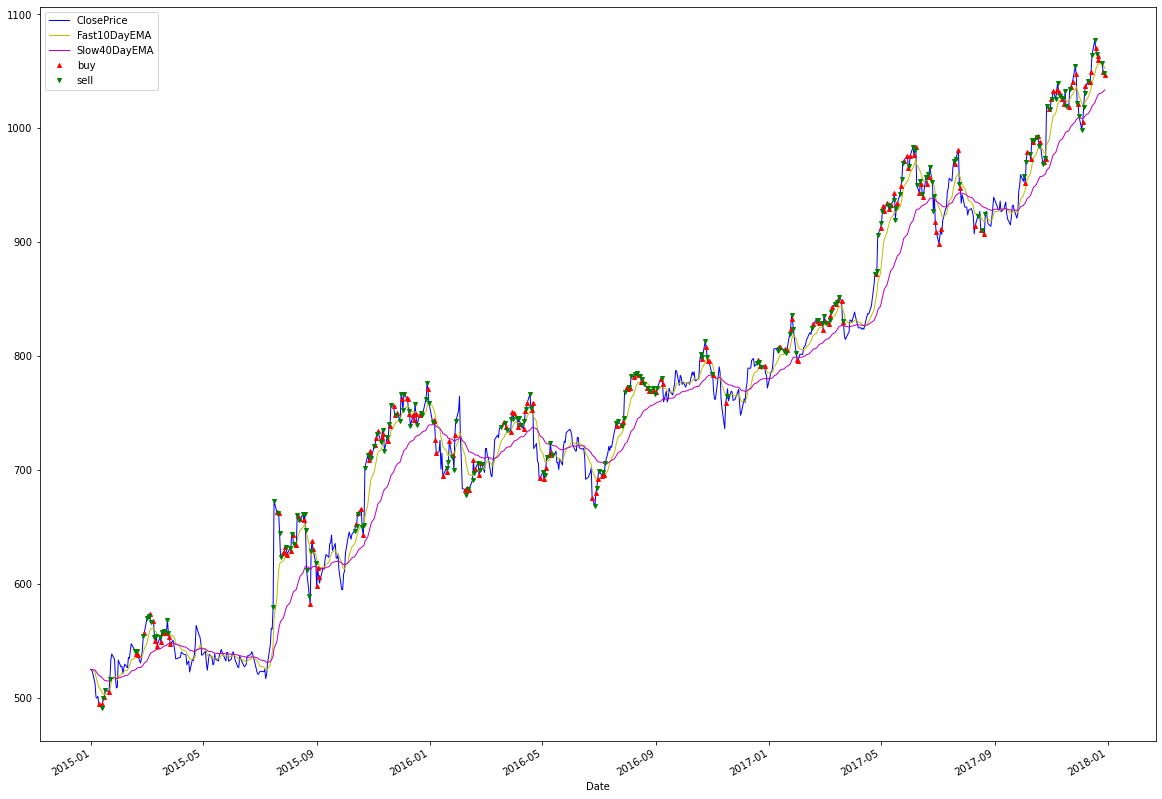

In [133]:
data['ClosePrice'].plot(color='blue', lw=1., legend=True, figsize = (20,15))
data['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
data['Slow40DayEMA'].plot(color='m', lw=1., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.ClosePrice[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=4, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.ClosePrice[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=4, label='sell')
plt.legend()
plt.show()


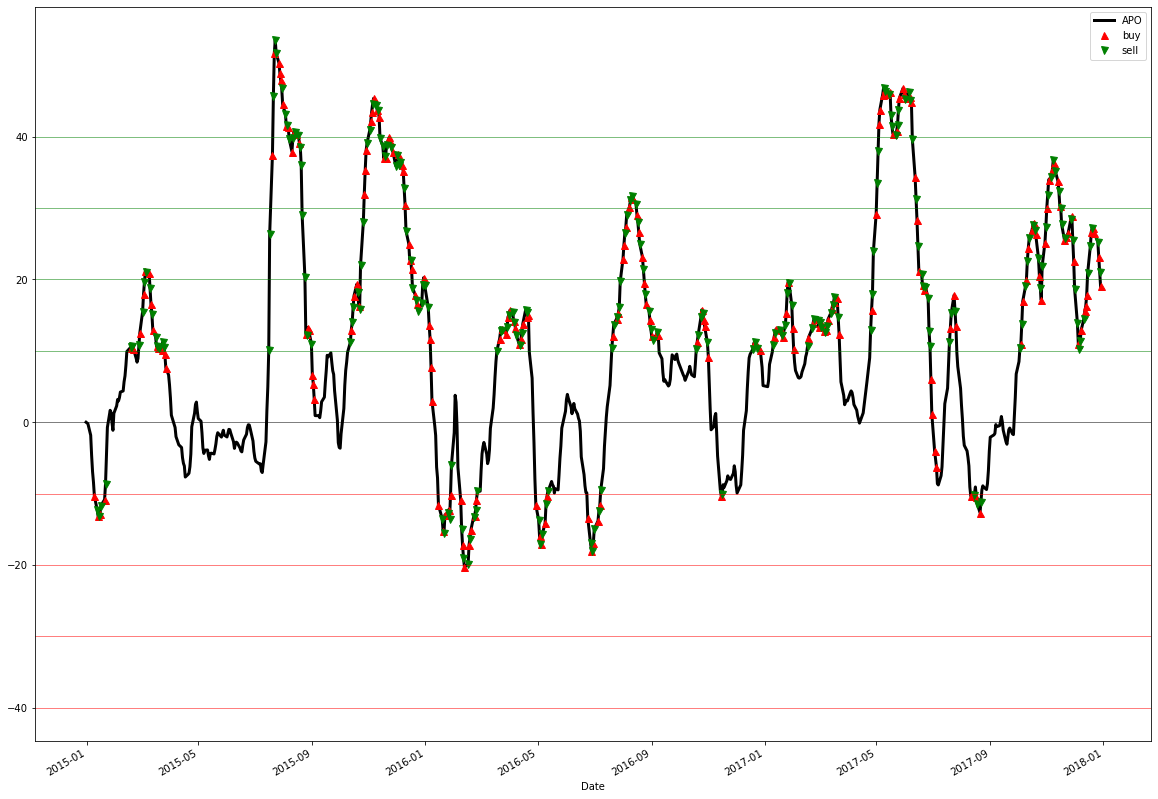

In [134]:
data['APO'].plot(color='k', lw=3., legend=True, figsize = (20,15))
plt.plot(data.loc[ data.Trades == 1 ].index, data.APO[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.APO[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

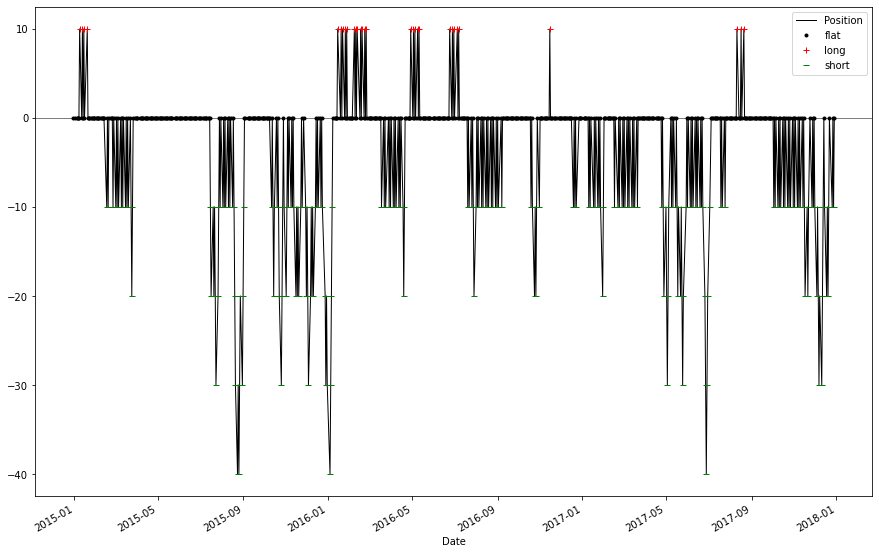

In [135]:
data['Position'].plot(color='k', lw=1., legend=True, figsize = (15,10))
plt.plot(data.loc[ data.Position == 0 ].index, data.Position[ data.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(data.loc[ data.Position > 0 ].index, data.Position[ data.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(data.loc[ data.Position < 0 ].index, data.Position[ data.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')

plt.legend()
plt.show()

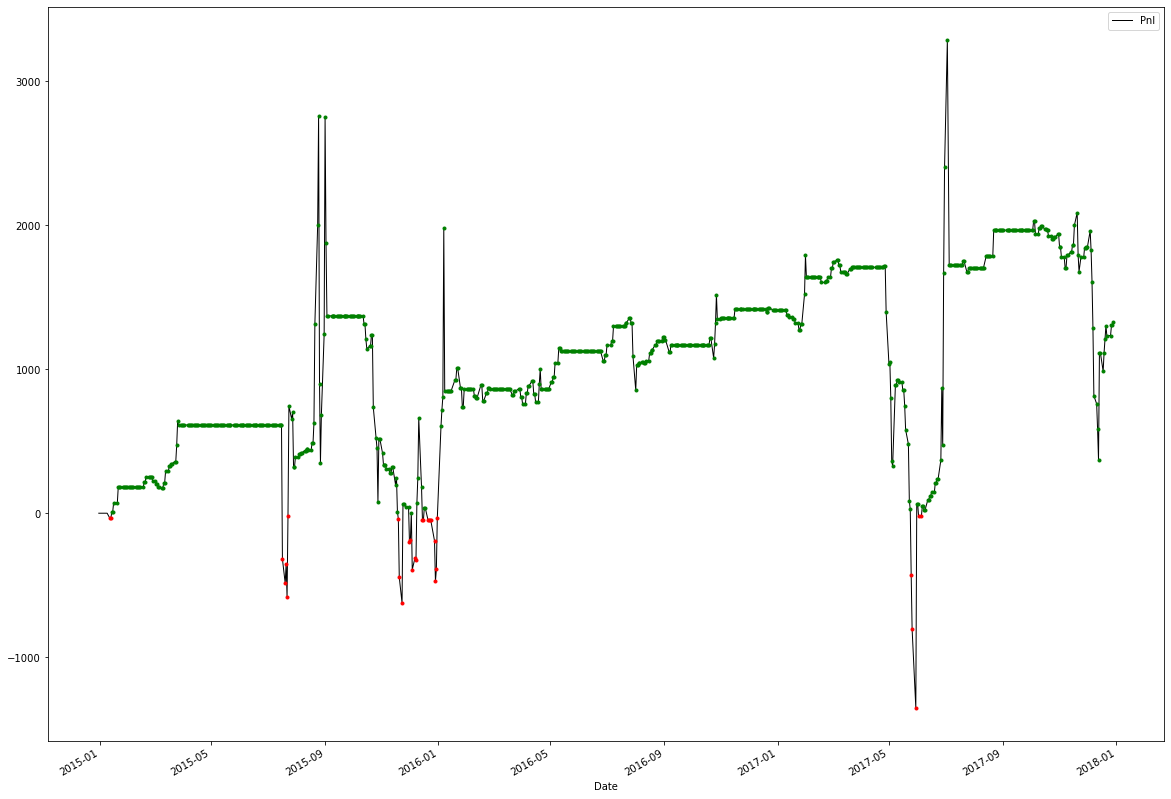

In [136]:
data['Pnl'].plot(color='k', lw=1., legend=True, figsize = (20,15))
plt.plot(data.loc[ data.Pnl > 0 ].index, data.Pnl[ data.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(data.loc[ data.Pnl < 0 ].index, data.Pnl[ data.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()